In [1]:
pip list | grep -E 'imageio|Pillow'

imageio                       2.9.0
imageio-ffmpeg                0.4.5
Pillow                        8.3.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [4]:
# 1회 이상 실행시 오류가 발생합니다.
! mkdir -p ~/aiffel/dcgan_newimage/fashion/generated_samples
! mkdir -p ~/aiffel/dcgan_newimage/fashion/training_checkpoints
! mkdir -p ~/aiffel/dcgan_newimage/fashion/training_history

In [5]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [6]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

In [7]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

In [8]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [9]:
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [10]:
train_x.shape

(60000, 28, 28)

In [11]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

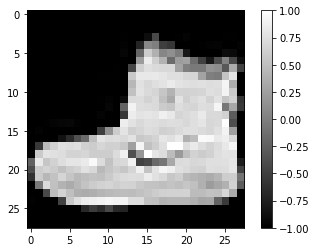

In [12]:
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()


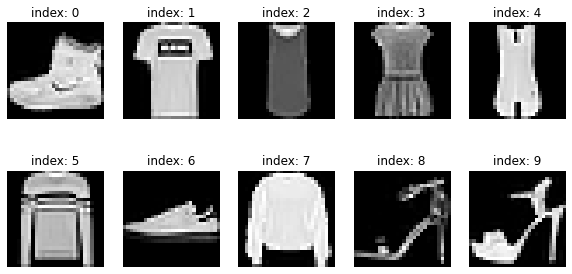

In [13]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

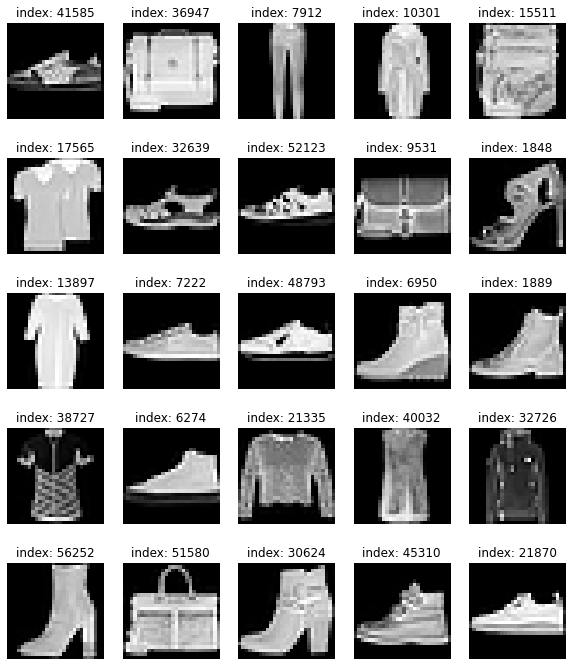

In [14]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 60000)
    plt.imshow(train_x[random_index].reshape(28, 28), cmap='gray')
    plt.title(f'index: {random_index}')

    plt.axis('off')

plt.show()

In [15]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [64]:

def make_generator_model():
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    # units은 7x7x256, 편향은 사용하지 않음, 입력 값의 크기는 100차원 벡터
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    # 커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    # 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [65]:
generator = make_generator_model()

generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_4 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 128)        

In [66]:
noise = tf.random.normal([1, 100])

In [67]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

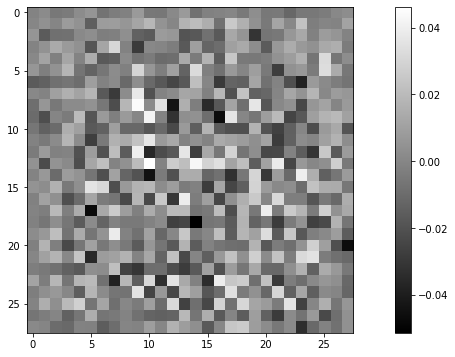

In [68]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

In [69]:
def make_discriminator_model():
    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    # 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 흑백 사진
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [70]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)             

In [71]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00442611]], dtype=float32)>

In [72]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [73]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

In [74]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [75]:
def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_output), real_output, from_logits=True)
    
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output, from_logits=True)
    
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    
    return total_loss

In [76]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [77]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [78]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [79]:
import numpy as np
import tensorflow as tf

def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([7, 7])

In [80]:
import numpy as np
import tensorflow as tf

@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

In [81]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값


(1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음\
(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함\
(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기\
(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성\
(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력\
(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산\
(7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산\
(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산\
(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신\
(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [82]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [83]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [84]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [85]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [86]:
save_every = 5
EPOCHS = 5

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

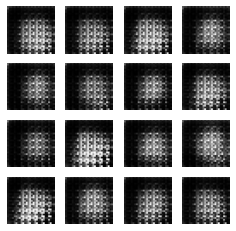

Epoch 1 | iter 201
Time for epoch 1 : 13 sec


ValueError: in user code:

    /tmp/ipykernel_80/927456118.py:14 train_step  *
        disc_loss = discriminator_loss(real_output, fake_output)
    /tmp/ipykernel_80/3813772332.py:9 discriminator_loss  *
        total_loss = real_loss + fake_loss
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1383 binary_op_wrapper
        raise e
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1367 binary_op_wrapper
        return func(x, y, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1700 _add_dispatch
        return gen_math_ops.add_v2(x, y, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_math_ops.py:464 add_v2
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:3561 _create_op_internal
        ret = Operation(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 96 and 256 for '{{node add}} = AddV2[T=DT_FLOAT](Mean, Mean_1)' with input shapes: [96], [256].


In [87]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.